In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
from collections import Counter
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn
from collections import defaultdict
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from sklearn.preprocessing import LabelEncoder
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import tensorflow as tf
from IPython.display import Image
import tensorflow_hub as hub
from sklearn.inspection import permutation_importance
import re
import spacy
from sklearn.pipeline import Pipeline

# Intoduction

With the introduction of chatGPT to the mainstream, it is harder than ever to differentiate between an AI and a real person leaving messages on the internet. One area that is particularly susceptible are reviews for products. A vendor might use chat bots to leave gushing reviews, enticing a consumer to chose their product over someone elses, only to be dissapointed with the end result. Fortunately, we are able to use machine learning to reasonably fight the waves of chatbot reviews. My goal with this project is to create a machine learning model that reliably discern between chatGPT reviews for products on amazon and real reviews. The dataset that I am using is one that was collected from Kaggle, and it can be found here: https://www.kaggle.com/datasets/mexwell/fake-reviews-dataset

This dataset was created by Joni Salminen and her team as a study to compare the effectiveness of people compared to machine learning algorithms in identifying fake reviews. The full study can be found here: https://www.sciencedirect.com/science/article/pii/S0969698921003374?via%3Dihub. Unfortunately, the fake reviews were created by GPT-2, which is easier to differentiate than GPT-3 or 4. My goals with this project are to:

* Perform exploratory data analysis on the reviews
* Preprocess the data so that it can be digested by machine learning algorithms
* Generate several baseline models including: naive bayes, decision tree, random forest, support vector machine and neural network
* Evaluate the effectiveness of all baseline models
* Choose the most effective baseline model, and tune its hyper parameters to create an even more effective model

# Load Data/ Exploratory Data Analyis

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/sphill12/Data_620/main/fake%20reviews%20dataset.csv", header = 0, names = ["category", "rating", "label", "text"])

df.head()

,category,rating,label,text
0,Home_and_Kitchen_5,5.0,CG,"Love this! Well made, sturdy, and very comfor..."
1,Home_and_Kitchen_5,5.0,CG,"love it, a great upgrade from the original. I..."
2,Home_and_Kitchen_5,5.0,CG,This pillow saved my back. I love the look and...
3,Home_and_Kitchen_5,1.0,CG,"Missing information on how to use it, but it i..."
4,Home_and_Kitchen_5,5.0,CG,Very nice set. Good quality. We have had the s...


In [3]:
df.isna().sum(axis= 0)

category    0
rating      0
label       0
text        0
dtype: int64

In [4]:
print(df.dtypes)
df["rating"] = df["rating"].astype("int")

category     object
rating      float64
label        object
text         object
dtype: object


We can change the "CG" and "OR" review labels to something easier to read for now:

In [5]:
df["label"] = df["label"].str.replace("CG", "Computer Generated")
df["label"] = df["label"].str.replace("OR", "Original Review")

In [6]:
## cleanup the category strings so that they look better when visualized
df["category"] = df["category"].apply(lambda x: x.strip("_5"))

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'Home_and_Kitchen'),
  Text(1, 0, 'Sports_and_Outdoors'),
  Text(2, 0, 'Electronics'),
  Text(3, 0, 'Movies_and_TV'),
  Text(4, 0, 'Tools_and_Home_Improvement'),
  Text(5, 0, 'Pet_Supplies'),
  Text(6, 0, 'Kindle_Store'),
  Text(7, 0, 'Books'),
  Text(8, 0, 'Toys_and_Games'),
  Text(9, 0, 'Clothing_Shoes_and_Jewelry')])

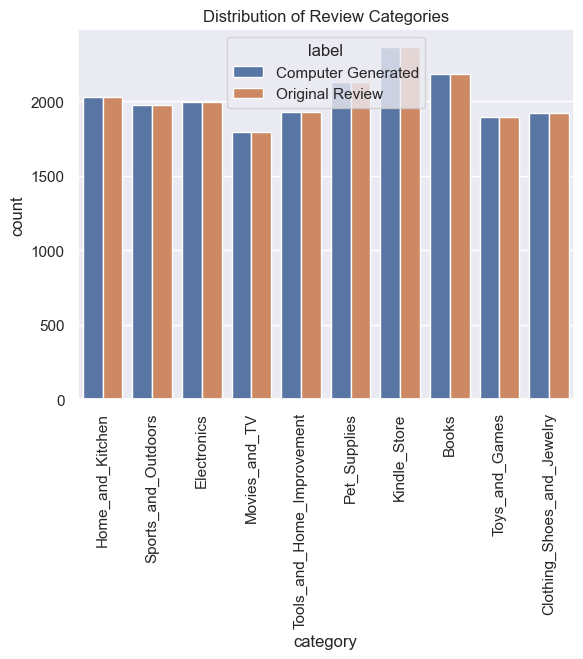

In [7]:
sns.set_theme()
sns.countplot(df, x = "category",hue = "label")
plt.title("Distribution of Review Categories")
plt.xticks(rotation = 90)

There are a variety of review categories that were given. Each of them has an equal amount of computer generated and human generated reviews. The counts for all the topics is not exactly the same, but is reasonably similar

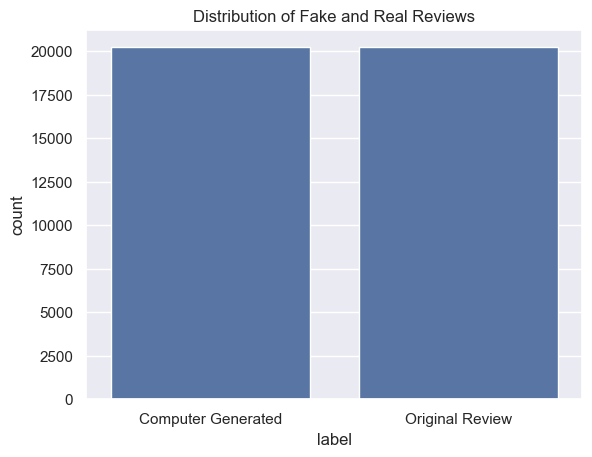

In [8]:
sns.countplot(df, x = "label")
plt.title("Distribution of Fake and Real Reviews")
plt.show()

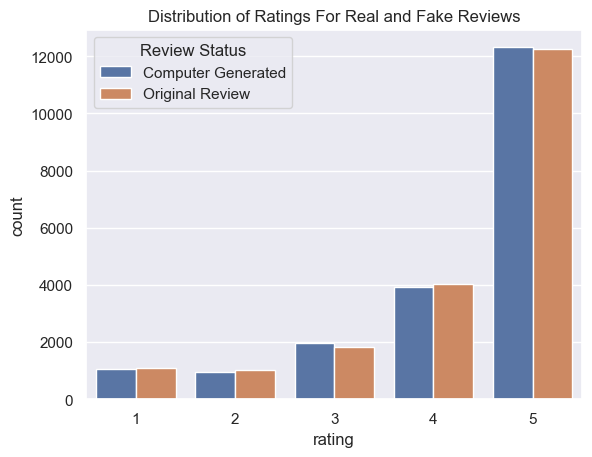

In [9]:
sns.countplot(df, x = "rating", hue= "label", legend = False)
plt.legend(title = "Review Status", labels = ["Computer Generated","Original Review"])
plt.title("Distribution of Ratings For Real and Fake Reviews")
plt.show()

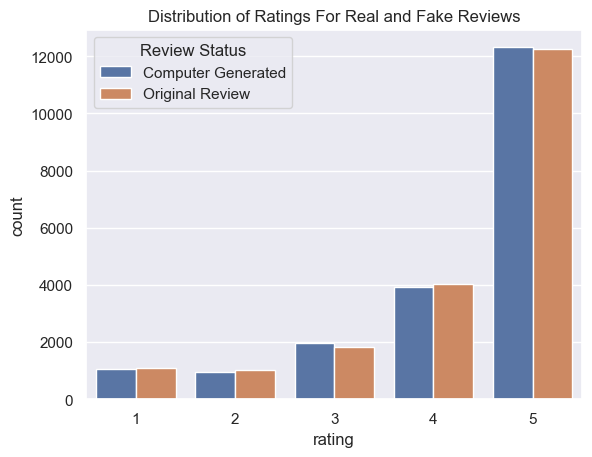

In [10]:
sns.countplot(df, x = "rating", hue= "label", legend = False)
plt.legend(title = "Review Status", labels = ["Computer Generated","Original Review"])
plt.title("Distribution of Ratings For Real and Fake Reviews")
plt.show()

The ratio of fake/real reviews is consistent across the ratings as well.


For our text,we can remove all stop words and visualize a word cloud of the most common terms:

In [11]:
## A quick function to remove the common stop words from a string

def remove_stop_words(string):
    stop_words =set(stopwords.words("english"))
    words = string.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    new_string = " ".join(filtered_words)
    return new_string

In [12]:
## Create a copy of the dataframe as the data will need to be preprocessed differently when it is being modeled

df2 = df.copy()
df2["text"] = df2["text"].apply(lambda x: remove_stop_words(x))
df2.head()

## Create counter object

def counter_obj(text):
    return Counter(text.split())

## Filter out the real reviews so that we can look at just the computer generated review wordcloud

word_count_rows = df2[df2["label"]== "Computer Generated"].text.apply(counter_obj)
total_word_count_cg = Counter()

for count in word_count_rows:
    total_word_count_cg.update(count)


total_word_count_cg_dict = dict(total_word_count_cg)

We have now generated the word cloud for GPT-2 reviews with the stop words removed:

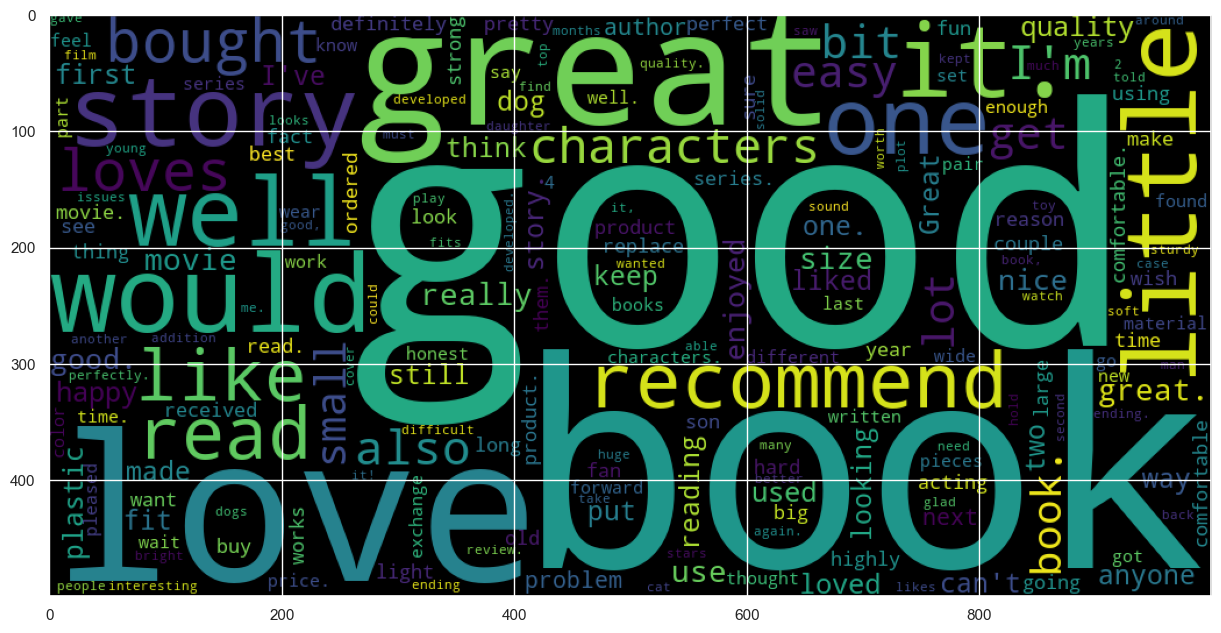

In [13]:
wc = WordCloud(width = 1000, height = 500).generate_from_frequencies(total_word_count_cg_dict)
plt.figure(figsize =(15,8))
plt.imshow(wc)

In [14]:
word_count_rows = df2[df2["label"]== "Original Review"].text.apply(counter_obj)
total_word_count_or = Counter()

for count in word_count_rows:
    total_word_count_or.update(count)

total_word_count_or_dict = dict(total_word_count_or)


Now we can view the word cloud for the real reviews:

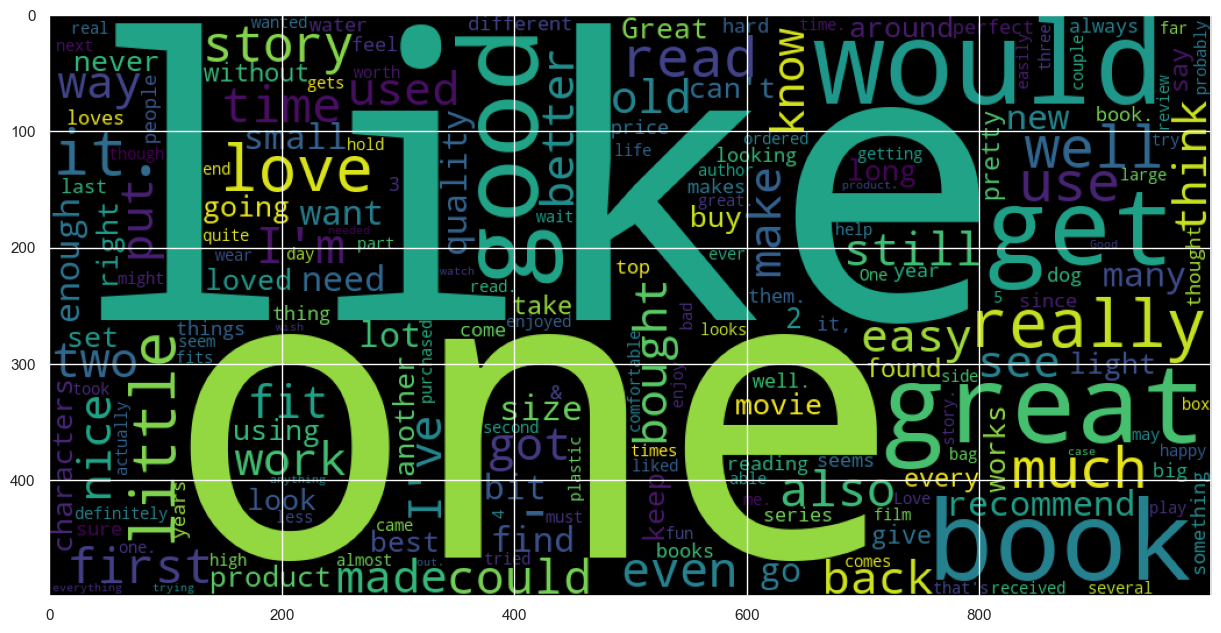

In [15]:
wc = WordCloud(width = 1000, height = 500).generate_from_frequencies(total_word_count_or_dict)
plt.figure(figsize =(15,8))
plt.imshow(wc)

Although the fequencies are different, there are no readily evident separators between the two word clouds. We will need the power of machine learning to differentiate them effectively

## Text Preprocessing

In order for machine learning models to effectively interpret our review strings, we will need to alter the text. There are steps for NLP projects that you should generally follow to generate effective data. The pipeline for preprocessing for our text classification will be as follows:

1. Make all words lowercase

    - This ensures that the model will not treat words with capitalizations as different entities that those without

1. Remove/handle special characters from the text
    
    - Special characters can interfere with how the algorithm interprets the strings. For some models, these symbols can be valuable information. Our data will have it's special characters removed

4. Stemming

    - This is when a word is reduced to its base form, for example the word "running" would be reduced to run. As our dataset will be a matrix indicating if a word is present, this helps to cut down on the size of the matrix

3. Do POS tagging

    - Part of speech tagging (POS) is the process of indicating a word in a text as being a particular element of speech. POS tagging will indicate whether a word is noun, verb, adjetive or adverb.This data is needed to perform lemmatization.



4. Lemmatize the words

    - Lemmatization is the process of breaking a word into its root meaning. This is similar to stemming, but helps to further reduce the size of our predictors. For example the word "better" would be reduced to "good". Stemming would be unable to make this transformation. In order to do lemmatization, the part of speech for a word must also be fed to the lemmatization model.
2. Tokenize the text
    
    - Tokenization is the process of splitting text strings into smaller units, which are called tokens, this means that every word is its own data point
5. Remove Stop words

    - Stop words are those that are filtered out becuase they are insignificant to training our model. Words such as "the" do not offer any valuable information, and are removed

6. Use bag of words/ TF-IDF to determine importance of words

    - There are two common methods to determine the importance of words in text. I will be testing both to determine their effectiveness. 
        
    -  Bag of words: In this text model, text is represented by an unordered collection of words, and the frequency of words in the text is identified. The frequency creates a proxy for the most important words in the text

    - Term Frequency - Inverse Document Frequency (TF-IDF): This is an alternate way of determining importance of words to documents in a collection of strings. The model weighs word important through the following two metrics

        - Term Frequency: This is represented by the relative frequency of a term within a document.
            
        - Inverse Document Frequency: This is a measure of how rare or common the word is across all documents.



In [16]:
## Separate our outcome from the predictors

y = df["label"]

X = df["text"]


## Turn all of our string data into lowercase

X = [text.lower() for text in X]

## Remove all punctuation from our strings

X = [re.sub(r'[^\w\s]',"", text) for text in X]


## Lemmatize our strings 

nlp= spacy.load("en_core_web_sm")

X_lemmatized = []

for doc in nlp.pipe(X):
    X_lemmatized.append(" ".join(token.lemma_ for token in doc))


X_tokenized = [word_tokenize(text) for text in X_lemmatized]



In [17]:
print(X_tokenized[0:50])

[['love', 'this', 'well', 'make', 'sturdy', 'and', 'very', 'comfortable', 'I', 'love', 'itvery', 'pretty'], ['love', 'it', 'a', 'great', 'upgrade', 'from', 'the', 'original', 'I', 've', 'have', 'mine', 'for', 'a', 'couple', 'of', 'year'], ['this', 'pillow', 'save', 'my', 'back', 'I', 'love', 'the', 'look', 'and', 'feel', 'of', 'this', 'pillow'], ['miss', 'information', 'on', 'how', 'to', 'use', 'it', 'but', 'it', 'be', 'a', 'great', 'product', 'for', 'the', 'price', 'I'], ['very', 'nice', 'set', 'good', 'quality', 'we', 'have', 'have', 'the', 'set', 'for', 'two', 'month', 'now', 'and', 'have', 'not', 'be'], ['I', 'want', 'different', 'flavor', 'but', 'they', 'be', 'not'], ['they', 'be', 'the', 'perfect', 'touch', 'for', 'I', 'and', 'the', 'only', 'thing', 'I', 'wish', 'they', 'have', 'a', 'little', 'more', 'space'], ['these', 'do', 'fit', 'well', 'and', 'look', 'great', 'I', 'love', 'the', 'smoothness', 'of', 'the', 'edge', 'and', 'the', 'extra'], ['great', 'big', 'number', 'easy', 'to

## Create train/test sets

We will make our bag of words train/test dataset first. The test size will be 20% of our dataset. We will create both a BOW dataset and a TF-IDF dataset. I will evaluate the performance of both of these on a naive bayes as it is simple and fast to run. The dataset with the best performance on this will be used to train the rest of the datasets.

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_lemmatized, df["label"], test_size = 0.2, random_state = 1249)

encoder = LabelEncoder()

y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)



## Now we can vectorize our data

count_vectorizer = CountVectorizer(lowercase= False)

count_train = count_vectorizer.fit_transform(X_train)
count_test = count_vectorizer.transform(X_test)



In [19]:
mapping = dict(zip(encoder.classes_, range(len(encoder.classes_)+1)))
print(mapping)

{'Computer Generated': 0, 'Original Review': 1}


Now we can do TF-IDF vectorization. The parameters for the vectorizer are common values that are set for pre processing text:

* max_features: Will limit the number of predictors that can go into our training matrix
* ngram_range: This will determine the token creation by our TfidfVectorizer. (1,2) means that our tokens can be unigrams or bigrams
* max_df: This is the cutoff threshold for when to remove certain tokens from our matrix. Terms that have a document frequency higher than this threshold will not be added

In [20]:
tfidf_vect = TfidfVectorizer(max_features = 30000, ngram_range = (1,2), min_df= 5, max_df = 0.6)
X_train_tfidf =tfidf_vect.fit_transform(X_train)
X_test_tfidf = tfidf_vect.transform(X_test)


## Create Base Models

I will be creating a naive bayes, decision tree, support vector machine, and neural network model. 

The effectiveness of the models will be evaluated by using:

1. Accuracy Score: This is the percentage of testing data that the model correctly classifies

2. Confusion matrix: This will provide us with a matrix that shows what classification item the model is best at classifying, and where the model incorrectly classifies data

3. Classification report: This report will give us the model measures of precision, recall and F1 score:
       
    * Precision: The proportion of positive identifications that are correct. Mathematically it is the number of true positives over the sum of the true positives and the false positives.
    * Recall: How often a model identifies true positives from all the actual positives in the dataset. Mathematically it is the number of true positives over the sum of true positives and false negatives.
    * F1 Score: F1 score integrages precision and recall into 1 metric so that the model with the best mixture of the two can be determined

A model that priorizes precision will care more about being right about the target class rather than finding all of them. Recall cares more about finding all of the metrics rather than being right about all of them. For our purposes, we will prioritize precision, as if we are detecting fake reviews, we do not want to accidentally remove correct reviews from our website. This could anger customers who are trying to voice how they feel about the product. F1 score will be very useful as well.

The first model that we will create is naive bayes. This model is great for getting a baseline for classification. We will test both the bag of words and TF-IDF preprocessed text

In [21]:
accuracy_dict= {}

nb_classifier = MultinomialNB()

nb_classifier.fit(count_train, y_train)
pred = nb_classifier.predict(count_test)
score=  metrics.accuracy_score(y_test, pred)
print(score)

accuracy_dict["Naive Bayes with B.O.W"] = score

print(metrics.classification_report(y_test, pred))




0.8524792877457648
              precision    recall  f1-score   support

           0       0.82      0.90      0.86      4026
           1       0.89      0.81      0.85      4061

    accuracy                           0.85      8087
   macro avg       0.86      0.85      0.85      8087
weighted avg       0.86      0.85      0.85      8087



In [22]:
cm= pd.DataFrame(metrics.confusion_matrix(y_test, pred, labels = [1,0]), index = ["true: Computer Generated","true: Original Review"], columns= ["pred: Computer Generated", "pred: Original Review"])
cm

,pred: Computer Generated,pred: Original Review
true: Computer Generated,3283,778
true: Original Review,415,3611


In [23]:
nb_classifier = MultinomialNB()

nb_classifier.fit(X_train_tfidf, y_train)
pred = nb_classifier.predict(X_test_tfidf)
score=  metrics.accuracy_score(y_test, pred)
print(score)

accuracy_dict["Naive Bayes with TF-IDF"] = score

print(metrics.classification_report(y_test, pred))

0.9047854581426982
              precision    recall  f1-score   support

           0       0.89      0.92      0.91      4026
           1       0.92      0.89      0.90      4061

    accuracy                           0.90      8087
   macro avg       0.91      0.90      0.90      8087
weighted avg       0.91      0.90      0.90      8087



In [24]:
metrics.confusion_matrix(y_test, pred)

array([[3712,  314],
       [ 456, 3605]], dtype=int64)

In [25]:
cm= pd.DataFrame(metrics.confusion_matrix(y_test, pred, labels = [1,0]), index = ["true: Computer Generated","true: Original Review"], columns= ["pred: Computer Generated", "pred: Original Review"])
cm

,pred: Computer Generated,pred: Original Review
true: Computer Generated,3605,456
true: Original Review,314,3712


### Support Vector Machine

The support vector machine is excellent for doing classification tasks. It operates by creating a hyperplance that distinguishes data points of different classes. The machine learning model is optimized when the largest margin possible separates the class data.

In [26]:
svm_tfidf = svm.SVC(C = 1.0 , kernel = "linear", degree = 3, gamma = "auto")

svm_tfidf.fit(X_train_tfidf, y_train)
predict = svm_tfidf.predict(X_test_tfidf)

score= metrics.accuracy_score(y_test, predict)
print("svm accuracy:", metrics.accuracy_score(y_test, predict) * 100)

accuracy_dict["SVM"] = score

print(metrics.classification_report(y_test, predict))

svm accuracy: 94.2871274885619
              precision    recall  f1-score   support

           0       0.95      0.94      0.94      4026
           1       0.94      0.95      0.94      4061

    accuracy                           0.94      8087
   macro avg       0.94      0.94      0.94      8087
weighted avg       0.94      0.94      0.94      8087



In [27]:
accuracy_dict


{'Naive Bayes with B.O.W': 0.8524792877457648,
 'Naive Bayes with TF-IDF': 0.9047854581426982,
 'SVM': 0.942871274885619}

In [28]:
cm= pd.DataFrame(metrics.confusion_matrix(y_test, predict, labels = [1,0]), index = ["true: Computer Generated","true: Original Review"], columns= ["pred: Computer Generated", "pred: Original Review"])
cm

,pred: Computer Generated,pred: Original Review
true: Computer Generated,3858,203
true: Original Review,259,3767


### Decision Tree

A decision tree operates by creating a set of hierarchal rules in which the algorithm follows in a set of branches, until it reaches its decision. To create the model, the algorithm determins the most important features and builds the rules based on this.

In [29]:
decision_tree_tfidf = DecisionTreeClassifier()
decision_tree_tfidf.fit(X_train_tfidf, y_train)

predict = decision_tree_tfidf.predict(X_test_tfidf)
score = metrics.accuracy_score(y_test, predict)

accuracy_dict["Decision Tree"] = score
print("decision tree accuracy", metrics.accuracy_score(y_test, predict) * 100)
print(metrics.classification_report(y_test, predict))

decision tree accuracy 78.47162112031656
              precision    recall  f1-score   support

           0       0.78      0.79      0.78      4026
           1       0.79      0.78      0.79      4061

    accuracy                           0.78      8087
   macro avg       0.78      0.78      0.78      8087
weighted avg       0.78      0.78      0.78      8087



In [30]:
cm= pd.DataFrame(metrics.confusion_matrix(y_test, predict, labels = [1,0]), index = ["true: Computer Generated","true: Original Review"], columns= ["pred: Computer Generated", "pred: Original Review"])
cm

,pred: Computer Generated,pred: Original Review
true: Computer Generated,3183,878
true: Original Review,863,3163


## Random Forest

Random forest is an extension of decision trees. Rather than have one tree with its rules, a random forest creates many different trees and combines the decisions from them to create a model that is more effective than one tree (most of the time).

In [31]:
random_forest_tfidf = RandomForestClassifier()
random_forest_tfidf.fit(X_train_tfidf, y_train)
predict = random_forest_tfidf.predict(X_test_tfidf)

print("Random Forest accuracy", metrics.accuracy_score(y_test, predict) * 100)

score = metrics.accuracy_score(y_test, predict)
accuracy_dict["Random Forest"] = score
print(metrics.classification_report(y_test, predict))

Random Forest accuracy 89.98392481760851
              precision    recall  f1-score   support

           0       0.91      0.88      0.90      4026
           1       0.89      0.92      0.90      4061

    accuracy                           0.90      8087
   macro avg       0.90      0.90      0.90      8087
weighted avg       0.90      0.90      0.90      8087



In [32]:
cm= pd.DataFrame(metrics.confusion_matrix(y_test, predict, labels = [1,0]), index = ["true: Computer Generated","true: Original Review"], columns= ["pred: Computer Generated", "pred: Original Review"])
cm

,pred: Computer Generated,pred: Original Review
true: Computer Generated,3729,332
true: Original Review,478,3548


In [33]:
feat_importances = pd.Series(random_forest_tfidf.feature_importances_ , index = tfidf_vect.vocabulary_.keys()).sort_values(ascending= False)

In [34]:
feat_importances[0:100]

deal it         0.010603
be perfectly    0.008982
expensive       0.006299
might want      0.005422
error in        0.005030
                  ...   
ago but         0.001627
store it        0.001593
sell it         0.001581
cry the         0.001572
it or           0.001517
Length: 100, dtype: float64

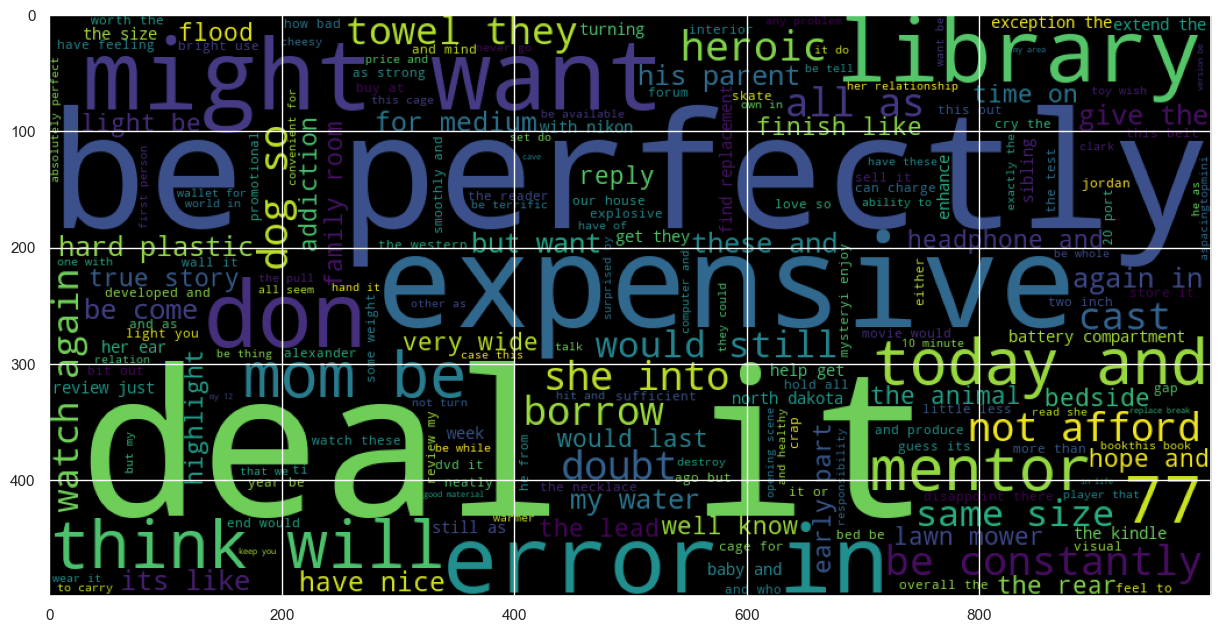

In [35]:
wc = WordCloud(width = 1000, height = 500).generate_from_frequencies(feat_importances.to_dict())
plt.figure(figsize =(15,8))
plt.imshow(wc)

In [36]:
print(feat_importances.to_dict())

{'deal it': 0.01060337833005016, 'be perfectly': 0.008981678920735542, 'expensive': 0.006299069260709505, 'might want': 0.005422047197807628, 'error in': 0.005029838600755994, 'don': 0.004911977894516024, 'library': 0.004661561646094434, 'think will': 0.0045642666830409415, '77': 0.0043515644098645065, 'today and': 0.004333260657486786, 'mom be': 0.00431765038295735, 'mentor': 0.004223391611946412, 'be constantly': 0.0041844544233012185, 'heroic': 0.004074048479314025, 'dog so': 0.004059507594579735, 'all as': 0.0039270703588289374, 'borrow': 0.0039115343176102, 'doubt': 0.0038387528209277485, 'not afford': 0.0037905538764134716, 'she into': 0.0037626105722743837, 'towel they': 0.0036812258008034086, 'cast': 0.003613376069925694, 'same size': 0.003479207050686765, 'watch again': 0.0033985322592398463, 'would still': 0.0032864592055779724, 'hard plastic': 0.0032553004831789674, 'these and': 0.003228235458026547, 'be come': 0.003176009778648005, 'my water': 0.0031662981347743775, 'give t

## Gradient Boosted

Gradient boosted models operate by creating using loss functions to help decision trees engage in weak learning to minimize the loss function. The model will stop learning after a threshold on the loss function is reached.

In [37]:
gradient_boost_tfidf = GradientBoostingClassifier()
gradient_boost_tfidf.fit(X_train_tfidf, y_train)
predict = gradient_boost_tfidf.predict(X_test_tfidf)

print("Gradient Boost Accuracy", metrics.accuracy_score(y_test, predict)* 100)

accuracy_dict["Gradient Boosted"] = metrics.accuracy_score(y_test, predict)

print(metrics.classification_report(y_test, predict))

Gradient Boost Accuracy 83.87535550884135
              precision    recall  f1-score   support

           0       0.87      0.79      0.83      4026
           1       0.81      0.88      0.85      4061

    accuracy                           0.84      8087
   macro avg       0.84      0.84      0.84      8087
weighted avg       0.84      0.84      0.84      8087



In [38]:
cm= pd.DataFrame(metrics.confusion_matrix(y_test, predict, labels = [1,0]), index = ["true: Computer Generated","true: Original Review"], columns= ["pred: Computer Generated", "pred: Original Review"])
cm

,pred: Computer Generated,pred: Original Review
true: Computer Generated,3584,477
true: Original Review,827,3199


## Neural Network

In [39]:
nn_model = tf.keras.Sequential([
                                    tf.keras.layers.Dense(16, activation= "relu"),
                                    tf.keras.layers.Dense(16, activation = "relu"),
                                    tf.keras.layers.Dense(1, activation= "sigmoid")
])

nn_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
                 loss = tf.keras.losses.BinaryCrossentropy(),
                 metrics = ["accuracy"])
                
nn_model.fit(X_train_tfidf,y_train, batch_size = 16, epochs =20)

nn_model.evaluate(X_test_tfidf, y_test)

accuracy_dict["Neural Network"]= nn_model.evaluate(X_test_tfidf, y_test)[1]

Epoch 1/20
2022/2022 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8808 - loss: 0.3254
Epoch 2/20
2022/2022 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9788 - loss: 0.0631
Epoch 3/20
2022/2022 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9946 - loss: 0.0212
Epoch 4/20
2022/2022 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9978 - loss: 0.0072
Epoch 5/20
2022/2022 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9995 - loss: 0.0023
Epoch 6/20
2022/2022 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 1.0000 - loss: 3.2428e-04
Epoch 7/20
2022/2022 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 1.0000 - loss: 7.7676e-05
Epoch 8/20
2022/2022 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9998 - loss: 2.8574e-04
Epoch 9/20
2022/2022 ━━━━━━━━━━━━━━━━━━━━ 2s 996us/step - accuracy: 1.0000 - loss: 3.4064e-05
Epoch 10/20
2022/2022 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 1.0000 - loss: 5.1225e-06
Epoch 11/20
2022/2022 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 1.0000 - loss: 4.1039e-06
Epoc

In [40]:
accuracy_dict["Neural Network"]= nn_model.evaluate(X_test_tfidf, y_test)[1]

253/253 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step - accuracy: 0.9314 - loss: 0.7330


## Model Accuracy Comparisons:

In [41]:
acc_df = pd.DataFrame.from_dict(accuracy_dict, orient = "index", columns = ["Accuracy"])
acc_df.sort_values(by = "Accuracy", ascending = False)

,Accuracy
SVM,0.942871
Neural Network,0.929269
Naive Bayes with TF-IDF,0.904785
Random Forest,0.899839
Naive Bayes with B.O.W,0.852479
Gradient Boosted,0.838754
Decision Tree,0.784716


## Tune Models:

To tune the models, I will be utilizing pipelines, as well as grid first search. The grid search that i'm using will be the randomsearchcv() function. Rather than iterate through all of the hyper parameters in my grid search, it will select random parameters. This will allow us to run a variety of parameters and estimate their effectiveness, while also saving time on the parameter selection. With more time, a full grid search should be run to maximize model performance. Along with this, the parameters that we will be running are cross validated. Cross validation divides our data into many different folds and uses one fold as a validation set and the rest as training data, which is repeated as many times as specified. The results from each validation step are averaged, meaning that the assessment of the effectiveness of the model is more reliable. It also help to prevent overfitting of the data. 

## Random Forest:

In [42]:
rf_pipe = Pipeline([("tfidf", TfidfVectorizer()),
                 ("rf", RandomForestClassifier())])
rf_pipe.get_params()

{'memory': None,
 'steps': [('tfidf', TfidfVectorizer()), ('rf', RandomForestClassifier())],
 'verbose': False,
 'tfidf': TfidfVectorizer(),
 'rf': RandomForestClassifier(),
 'tfidf__analyzer': 'word',
 'tfidf__binary': False,
 'tfidf__decode_error': 'strict',
 'tfidf__dtype': numpy.float64,
 'tfidf__encoding': 'utf-8',
 'tfidf__input': 'content',
 'tfidf__lowercase': True,
 'tfidf__max_df': 1.0,
 'tfidf__max_features': None,
 'tfidf__min_df': 1,
 'tfidf__ngram_range': (1, 1),
 'tfidf__norm': 'l2',
 'tfidf__preprocessor': None,
 'tfidf__smooth_idf': True,
 'tfidf__stop_words': None,
 'tfidf__strip_accents': None,
 'tfidf__sublinear_tf': False,
 'tfidf__token_pattern': '(?u)\\b\\w\\w+\\b',
 'tfidf__tokenizer': None,
 'tfidf__use_idf': True,
 'tfidf__vocabulary': None,
 'rf__bootstrap': True,
 'rf__ccp_alpha': 0.0,
 'rf__class_weight': None,
 'rf__criterion': 'gini',
 'rf__max_depth': None,
 'rf__max_features': 'sqrt',
 'rf__max_leaf_nodes': None,
 'rf__max_samples': None,
 'rf__min_impu

Now we can add a grid search using our available parameters. The parameters that we are adjusting:

tfidf max features: This determines the maximum size of our matrix of predictors when we apply the tfidf transformer

tfidf max df: This is the cutoff point for our frequency of words. Words that appear in documents above the threshold that we have set will be removed from our matrix of predictors

Ngram range: This determines the size of our tokens

max depth: Decision trees with higher max depths are allowed to make more decisions before classifying. This can lead to overfitting though

min samples leaf: The amount of samples that are required at a leaf node (node with no children). If we set a minimum amount of samples then we can prevent data overfitting

rf criterion: The mathematical criterion used to determine the optimal split

Our original random forest model had an accuracy of: 90.08284901694077

In [43]:
max_depth = [int(x) for x in np.linspace(10,1000,10)]
grid_params = {"tfidf__max_features":(10000,20000,30000,None),
               "tfidf__max_df":(0.5,0.6,0.75,1),
               "tfidf__ngram_range" : ((1,1), (1,2), (1,3),),
               "tfidf__use_idf": (True, False),
               "rf__max_depth": max_depth,
               "rf__min_samples_split": [2,5,10,20],
               "rf__min_samples_leaf":[1,2,4,6,8],
               "rf__criterion": ["entropy","gini"],
               }

In [44]:
gs = RandomizedSearchCV(rf_pipe, grid_params,  scoring = "accuracy", n_iter = 20)
gs.fit(X_train_tfidf, y_train)

ValueError: 
All the 100 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
100 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Python312\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Python312\Lib\site-packages\sklearn\pipeline.py", line 471, in fit
    Xt = self._fit(X, y, routed_params)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Python312\Lib\site-packages\sklearn\pipeline.py", line 408, in _fit
    X, fitted_transformer = fit_transform_one_cached(
                            ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Python312\Lib\site-packages\joblib\memory.py", line 353, in __call__
    return self.func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Python312\Lib\site-packages\sklearn\pipeline.py", line 1303, in _fit_transform_one
    res = transformer.fit_transform(X, y, **params.get("fit_transform", {}))
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Python312\Lib\site-packages\sklearn\feature_extraction\text.py", line 2138, in fit_transform
    X = super().fit_transform(raw_documents)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Python312\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Python312\Lib\site-packages\sklearn\feature_extraction\text.py", line 1389, in fit_transform
    vocabulary, X = self._count_vocab(raw_documents, self.fixed_vocabulary_)
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Python312\Lib\site-packages\sklearn\feature_extraction\text.py", line 1276, in _count_vocab
    for feature in analyze(doc):
                   ^^^^^^^^^^^^
  File "c:\Python312\Lib\site-packages\sklearn\feature_extraction\text.py", line 110, in _analyze
    doc = preprocessor(doc)
          ^^^^^^^^^^^^^^^^^
  File "c:\Python312\Lib\site-packages\sklearn\feature_extraction\text.py", line 68, in _preprocess
    doc = doc.lower()
          ^^^^^^^^^
AttributeError: 'csr_matrix' object has no attribute 'lower'. Did you mean: 'power'?


Best Score of train set: 0.9063533776472406


Test Score: 0.9072585631260047


Best paramters: {'tfidf__use_idf': False, 'tfidf__ngram_range': (1, 2), 'tfidf__max_features': None, 'tfidf__max_df': 0.5, 'rf__min_samples_split': 5, 'rf__min_samples_leaf': 1, 'rf__max_depth': 450, 'rf__criterion': 'entropy'} None

In [ ]:
print("Best Score of train set:", str(gs.best_score_))
print("Best paramters:", str(gs.best_params_),
print("Test Score:", str(gs.score(X_test_tfidf, y_test))))

NameError: name 'gs' is not defined

## Support Vector Machine:

This will likely be our final model. The parameters that we will adjust will be:

* SVM Kernel: The kernel is a way in which the decision boundary can be tranformed into a non linear, high dimensionality space. The kernel chosen change how this is accomplished

* SVM C: This parameter determines the penalty for misclassification in data points during training. A smaller C allows for more misclassifications

* SVM gamma: Gamma determines how influencial an individual training parameter is on fitting the decision boundary. A high gamma may cause overfitting

Our baseline model had an accuracy of: 94.2871274885619

In [ ]:
svm_pipe = Pipeline([("tfidf", TfidfVectorizer()),
                 ("svm", svm.SVC())])
svm_pipe.get_params()

{'memory': None,
 'steps': [('tfidf', TfidfVectorizer()), ('svm', SVC())],
 'verbose': False,
 'tfidf': TfidfVectorizer(),
 'svm': SVC(),
 'tfidf__analyzer': 'word',
 'tfidf__binary': False,
 'tfidf__decode_error': 'strict',
 'tfidf__dtype': numpy.float64,
 'tfidf__encoding': 'utf-8',
 'tfidf__input': 'content',
 'tfidf__lowercase': True,
 'tfidf__max_df': 1.0,
 'tfidf__max_features': None,
 'tfidf__min_df': 1,
 'tfidf__ngram_range': (1, 1),
 'tfidf__norm': 'l2',
 'tfidf__preprocessor': None,
 'tfidf__smooth_idf': True,
 'tfidf__stop_words': None,
 'tfidf__strip_accents': None,
 'tfidf__sublinear_tf': False,
 'tfidf__token_pattern': '(?u)\\b\\w\\w+\\b',
 'tfidf__tokenizer': None,
 'tfidf__use_idf': True,
 'tfidf__vocabulary': None,
 'svm__C': 1.0,
 'svm__break_ties': False,
 'svm__cache_size': 200,
 'svm__class_weight': None,
 'svm__coef0': 0.0,
 'svm__decision_function_shape': 'ovr',
 'svm__degree': 3,
 'svm__gamma': 'scale',
 'svm__kernel': 'rbf',
 'svm__max_iter': -1,
 'svm__probabi

In [ ]:
svm_grid_params = {
               "svm__kernel" : ["linear","poly","rbf","sigmoid","precomputed"], 
               "svm__C" :[0.1, 1,10, 100],
               "svm__gamma" : [1,0.1,0.01,0.001, 0.0001,"scale"]
               
}

In [ ]:
gs_svm = GridSearchCV(svm_pipe, svm_grid_params,  scoring = "accuracy")
gs_svm.fit(X_train_tfidf, y_train)

c:\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
5 fits failed out of a total of 25.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Python312\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Python312\Lib\site-packages\sklearn\pipeline.py", line 475, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Pyth

GridSearchCV(estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('svm', SVC())]),
             param_grid={'svm__kernel': ['linear', 'poly', 'rbf', 'sigmoid',
                                         'precomputed']},
             scoring='accuracy')

Best Score of train set: 0.9450919771216573
Test Score: 0.9521454185730184
Best paramters: {'tfidf__use_idf': True, 'tfidf__ngram_range': (1, 3), 'tfidf__max_features': None, 'tfidf__max_df': 0.6, 'svm__kernel': 'rbf', 'svm__gamma': 0.01, 'svm__C': 100} None

Optimal parameters that will be chosen with current testing:

Best paramters: {'tfidf__use_idf': True, 'tfidf__ngram_range': (1, 3), 'tfidf__max_features': None, 'tfidf__max_df': 0.6, 'svm__kernel': 'rbf', 'svm__gamma': 0.01, 'svm__C': 100} None

## Conclusion:

Machine learning models that are trained to detect fraudulent reviews can be extremely effective. Even with base models, up to a 95% accuracy can be reached using models such as SVM or a neural network. One of most important parts of text based classification is the way that the text is preprocessed. Important decisions such as whether to leave in punctuation, allow bigrams, lemmatize/stem, and the removal of stop words all can greatly effect the model performance. To determine the best training data structure and hyper parameters, a machine learning pipeline should be constructed that makes use of a grid search along with cross validation to ensure that the model doesn't overfit the training data. Ultimately if we were to choose a model, SVM had the best performance. It had a high accuracy, precision, recall and f1 score. With tuning of the C, gamma and kernal the accuracy of the model was taken from 94% to 95% even with cross validation. Further ways to possibly squeeze more accuracy out of the model would be to create a wider tuning grid on these parameters, as well as experiment more on the tuning grid for the tf-idf transformations. Overall though, a 95% accuracy is extremely good. It is possible that the model would be more suited for real life scenarios if it was adjusted to be less accurate, but misclassify fewer real reviews as being AI generated.